In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv("cleaned_data.csv")
y = df['decision']
df

,resume_Text,job_description_text,decision,job_id
0,SummaryForward-thinking Project Management Pro...,Experienced in Salesforce Industries Communic...,0,0
1,Professional ProfileExpert in Functional Testi...,Experienced in Salesforce Industries Communic...,0,0
2,Professional SummaryA professional position in...,Experienced in Salesforce Industries Communic...,0,0
3,SummaryWorking with a $100 million company uti...,Experienced in Salesforce Industries Communic...,0,0
4,"Professional SummaryDependable, results-driven...",Experienced in Salesforce Industries Communic...,0,0
...,...,...,...,...
4824,"Professional SummaryDependable, results-driven...","Your Journey at Crowe Starts Here:\nAt Crowe, ...",1,189
4825,SummarySelf-motivated Data Analyst offering 8 ...,"Your Journey at Crowe Starts Here:\nAt Crowe, ...",1,189
4826,"Career OverviewDedicated, personable, and moti...","Your Journey at Crowe Starts Here:\nAt Crowe, ...",1,189
4827,"SummaryA results driven, detail-oriented data ...","Your Journey at Crowe Starts Here:\nAt Crowe, ...",1,189


In [3]:
model = SentenceTransformer('all-MiniLM-L6-v2')
resume_embeddings = model.encode(df['resume_Text'].tolist(), show_progress_bar=True)
job_embeddings = model.encode(df['job_description_text'].tolist(), show_progress_bar=True)

X = np.concatenate([resume_embeddings, job_embeddings], axis=1)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/151 [00:00<?, ?it/s]

Batches:   0%|          | 0/151 [00:00<?, ?it/s]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=df['job_id'], test_size=0.2, random_state=42)

In [5]:
train_accuracies = {}
test_accuracies = {}

In [6]:
def evaluate_model_acc(name, model, keras=False):
    if keras:
        train_pred = (model.predict(X_train).flatten() >= 0.5).astype(int)
        test_pred = (model.predict(X_test).flatten() >= 0.5).astype(int)
    else:
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
    train_accuracies[name] = accuracy_score(y_train, train_pred)
    test_accuracies[name] = accuracy_score(y_test, test_pred)

In [7]:
#Cosine Similarities
cosine_scores = cosine_similarity(resume_embeddings, job_embeddings).diagonal()
df['bert_cosine_score'] = cosine_scores


In [8]:
#Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
df['bert_lr_score'] = lr_model.predict_proba(X)[:, 1]
evaluate_model_acc("Logistic Regression", lr_model)

In [9]:
#Random Forest
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)
df['bert_rf_score'] = rf_model.predict_proba(X)[:, 1]
evaluate_model_acc("Random Forest", rf_model)

In [10]:
#LinearSVC
svc_model = LinearSVC()
svc_model.fit(X_train, y_train)
df['bert_svc_score'] = svc_model.decision_function(X)
evaluate_model_acc("LinearSVC", svc_model)

In [11]:
#XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
df['bert_xgb_score'] = xgb_model.predict_proba(X)[:, 1]
evaluate_model_acc("XGBoost", xgb_model)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:03:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [12]:
#LightGBM
lgb_model = LGBMClassifier()
lgb_model.fit(X_train, y_train)
df['bert_lgb_score'] = lgb_model.predict_proba(X)[:, 1]
evaluate_model_acc("LightGBM", lgb_model)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2093, number of negative: 1770
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 175935
[LightGBM] [Info] Number of data points in the train set: 3863, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.541807 -> initscore=0.167619
[LightGBM] [Info] Start training from score 0.167619


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [26]:
#Keras Neural Network
nn_model = Sequential([
    Input(shape=(X.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_nn = nn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, verbose=0)
evaluate_model_acc("Keras NN", nn_model, keras=True)
df['bert_nn_score'] = nn_model.predict(X).flatten()

121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [14]:
#Naive Bayes (Gaussian)
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
df['bert_nb_score'] = nb_model.predict_proba(X)[:, 1]
evaluate_model_acc("Naive Bayes", nb_model)

In [15]:
#K-Nearest Neighbors
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
df['bert_knn_score'] = knn_model.predict_proba(X)[:, 1]
evaluate_model_acc("KNN", knn_model)

In [17]:
#Siamese Network
X1 = resume_embeddings
X2 = job_embeddings
y_array = np.array(y)
X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(
    X1, X2, y_array, stratify=df['job_id'], test_size=0.2, random_state=42)

embedding_dim = X1.shape[1]
input_a = Input(shape=(embedding_dim,))
input_b = Input(shape=(embedding_dim,))

shared_net = Sequential([
    Dense(256, activation='relu', input_shape=(embedding_dim,)),
    Dropout(0.3),
    Dense(128, activation='relu')
])

encoded_a = shared_net(input_a)
encoded_b = shared_net(input_b)

l1_distance = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))
merged = l1_distance([encoded_a, encoded_b])
output = Dense(1, activation='sigmoid')(merged)

siamese_model = Model(inputs=[input_a, input_b], outputs=output)
siamese_model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
history_siamese = siamese_model.fit([X1_train, X2_train], y_train, validation_data=([X1_test, X2_test], y_test), batch_size=32, epochs=10, verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
df['bert_siamese_score'] = siamese_model.predict([X1, X2]).flatten()
train_pred_siamese = (siamese_model.predict([X1_train, X2_train]).flatten() >= 0.5).astype(int)
test_pred_siamese = (siamese_model.predict([X1_test, X2_test]).flatten() >= 0.5).astype(int)
train_accuracies['Siamese NN'] = accuracy_score(y_train, train_pred_siamese)
test_accuracies['Siamese NN'] = accuracy_score(y_test, test_pred_siamese)

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [20]:
def evaluate_model(name, y_true, y_score):

    acc = accuracy_score(y_true, y_score >= 0.5)
    print(f"{name}: Accuracy = {acc:.4f}")

def print_all_model_accuracies():
    print("\n📊 Train vs Test Accuracy Summary:")
    print(f"{'Model':<20} {'Train Accuracy':<18} {'Test Accuracy':<18}")
    print("-" * 60)
    for name in train_accuracies:
        print(f"{name:<20} {train_accuracies[name]:<18.4f} {test_accuracies[name]:<18.4f}")


print_all_model_accuracies()
evaluate_model("BERT Cosine Similarity", y, df['bert_cosine_score'])


📊 Train vs Test Accuracy Summary:
Model                Train Accuracy     Test Accuracy     
------------------------------------------------------------
Logistic Regression  0.6966             0.6149            
Random Forest        0.9997             0.6698            
LinearSVC            0.7313             0.6470            
XGBoost              0.9997             0.6894            
LightGBM             0.9977             0.7008            
Keras NN             0.8307             0.7081            
Naive Bayes          0.6057             0.5828            
KNN                  0.7455             0.6159            
Siamese NN           0.8460             0.7101            
BERT Cosine Similarity: Accuracy = 0.5281


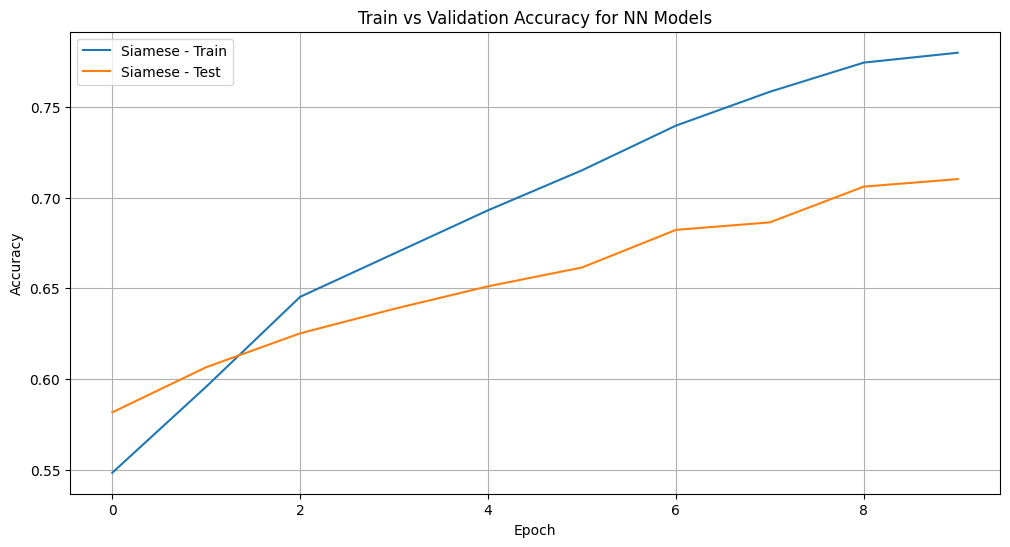

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(history_siamese.history['accuracy'], label='Siamese - Train')
plt.plot(history_siamese.history['val_accuracy'], label='Siamese - Test')
plt.title('Train vs Validation Accuracy for NN Models')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

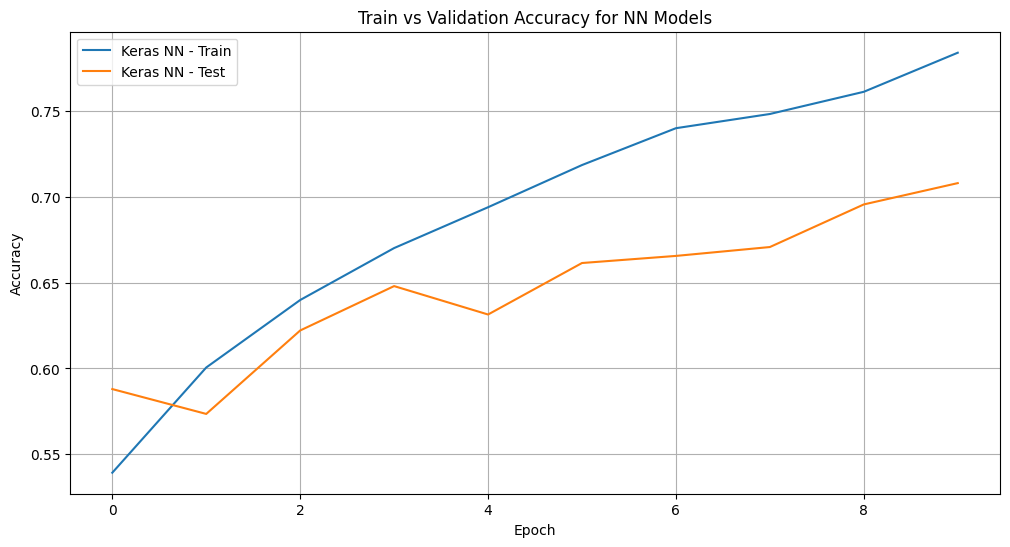

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(history_nn.history['accuracy'], label='Keras NN - Train')
plt.plot(history_nn.history['val_accuracy'], label='Keras NN - Test')
plt.title('Train vs Validation Accuracy for NN Models')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

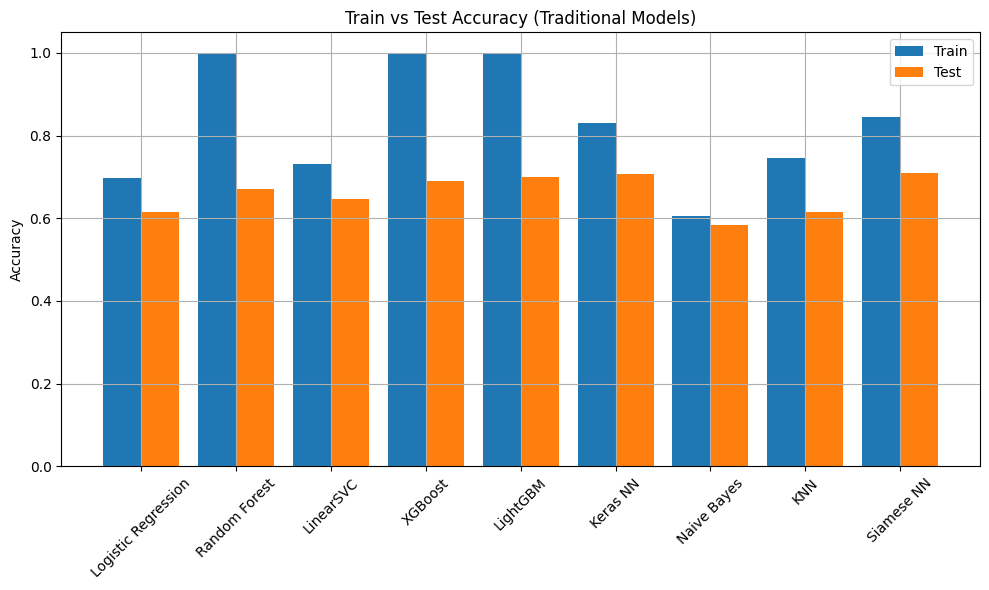

In [24]:
plt.figure(figsize=(10, 6))
labels = list(train_accuracies.keys())
train_vals = list(train_accuracies.values())
test_vals = list(test_accuracies.values())

x = range(len(labels))
plt.bar([i - 0.2 for i in x], train_vals, width=0.4, label='Train')
plt.bar([i + 0.2 for i in x], test_vals, width=0.4, label='Test')
plt.xticks(x, labels, rotation=45)
plt.ylabel("Accuracy")
plt.title("Train vs Test Accuracy (Traditional Models)")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


In [27]:
df[[
    'job_id', 'decision',
    'bert_lr_score','bert_rf_score', 'bert_svc_score',
    'bert_xgb_score', 'bert_lgb_score','bert_nn_score', 'bert_nb_score', 'bert_knn_score',
    'bert_siamese_score']].to_csv("bert_model_scores.csv", index=False)